In [186]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import cm
import matplotlib.patches
from ipywidgets import interactive
import ipywidgets as widgets
from ipywidgets import Layout, Button, Box, VBox,Label
import plotly as ply
from dance_sim_tools import trace_objects,utility
from dance_sim_tools.utility import histogram_draw_to_parameters as htp
from dance_sim_tools.utility import draw_reversal_distances_tm
from dance_sim_tools.ipywidget_helpers import slider,intslider
import pandas as pd
import dance_sim_tools.trace_objects as trace_objects
import warnings
warnings.filterwarnings('ignore')
import scipy.stats


In [187]:
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
            spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
        ax.tick_params(direction='in', length=6, width=2, colors='k',grid_color='k', grid_alpha=0.5)
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

In [188]:
def rads_to_bls(theta):
    return np.degrees(theta)*(np.pi/9)/2.4
def degs_to_bls(theta):
    return theta*(np.pi/9)/2.4

num_flies = 23

# flies_to_exclude = [0,4,6,8,9,12]
# which_flies_bool = np.ones(num_flies).astype(bool)
# which_flies_bool[flies_to_exclude] = False
# which_flies_list = np.where(which_flies_bool)[0]

which_flies_list = np.arange(1,num_flies+1,1)

#Specify which trials involved finding the food, for each list (from Amir's email 9/23 11:26AM)
#Boolean of shape flies x max_num_trials
which_trials_bool = np.zeros((num_flies,6)).astype(bool)
which_trials_dict = {1:[1,2,3,4,5],
    2:[1,2],
    3:[1,2,3,4,5,6],
    4:[1,2,3,4,5,6],
    5:[1,2,3,4,5,6],
    6:[1,2,3,4,5],
    7:[1,2,3,4,5,6],
    8:[1,2,3,5,6],
    9:[1,2,3,4,5],
    10:[1,2,3,4,5],
    11:[1,2,3,4,5,6],
    12:[1,2,3,4,5,6],
    13:[1,2,5],
    14:[1,2,3,4,5,6],
    15:[1,2,3,4,5,6],
    16:[1,2,3],
    17:[1,2],
    18:[1,2,3,4,5,6],
    19:[1,2,3,4,5,6],
    20:[1,2,3,4,5],
    21:[1,2,3,4,6],
    22:[1,2,3,4,6],
    23:[2,4,5]}
for fly in range(1,num_flies+1):
    which_trials = np.array(which_trials_dict[fly])-1
    which_trials_bool[fly-1,which_trials] = True

theta and time signal location:

'dance_sim_jupyter/5by5_data_923/Annie_Data_trial_1food/' and the format is

'{theta/t}_1F_{af/be/du}_{fly_num}_{trial_num}.txt'




In [189]:
#First we need to compute the ballpark size numner of timepoints
file_loc = '5by5_data_923/Annie_Data_trial_1food/'
t_signals = []
which_periods_nums = [0,1,2]
fly_num=1
which_trials=1
for period_ind in which_periods_nums:
    
    t_filename = file_loc+'t_1F_'+\
        ['be','du','af'][period_ind]+'_'+\
        str(fly_num)+'_'+\
        str(which_trials)+'.txt'
    t_signal = pd.read_csv(t_filename).values.T[0]


    while (t_signal[0]<period_ind*5):
        t_signal = t_signal + 5

    t_signals.append(t_signal)

t_signal = np.hstack(t_signals)
t_sample_len = float(np.shape(t_signal)[0])
digits = 4
num_time_steps = int(np.ceil(t_sample_len/(10**digits))*(10**digits))

num_time_steps
#num_time_steps is meant to be an upper bound on the number of time/theta inds we see in any 
#given bef/dur/af concatented traces

30000

In [190]:
def plot_single_trace(fly_num,which_trials,which_periods,d_max,show_led=False):
     
    #fly_num: which fly ids to plot (1-indexed!)
    #which_trials: a matrix specifying which trials to include for each fly (1-indexed!)
    #which_periods: for each fly, 3-element bool specifying whether to show [before,during,after] (0-indexed)
    #d_max: the theta bounds to use for the plot
    #show_led: (we don't have it yet 9/23)
    
    file_loc = '5by5_data_923/Annie_Data_trial_1food/'
       
    which_periods_nums= [{'before':0,'during':1,'after':2}[which_period] for which_period in which_periods]
    
    which_trial_list = np.arange(which_trials[0],which_trials[1]+1)
    num_trials = len(which_trial_list)
    shape = (num_trials,num_time_steps)
    theta_signals = np.full(shape,np.nan)
    t_signals = np.full(shape,np.nan)
    
    for trial in which_trial_list:
        
        
                #Check if this fly-trial pair the food was found and skip if not
        if(which_trials_bool[fly_num-1,trial-1]): 

            start_t_ind = 0

            for period_ind in which_periods_nums:

                theta_filename = file_loc+'theta_1F_'+\
                    ['be','du','af'][period_ind]+'_'+\
                    str(fly_num)+'_'+\
                    str(trial)+'.txt'

                t_filename = file_loc+'t_1F_'+\
                    ['be','du','af'][period_ind]+'_'+\
                    str(fly_num)+'_'+\
                    str(trial)+'.txt'

                theta_signal = pd.read_csv(theta_filename).values.T[0]
                t_signal = pd.read_csv(t_filename).values.T[0]

                while (t_signal[0]<period_ind*5):
                    t_signal = t_signal + 5

                len_signal = len(t_signal)

                t_signals[trial-1,start_t_ind:start_t_ind+len_signal] = t_signal       
                theta_signals[trial-1,start_t_ind:start_t_ind+len_signal] = theta_signal      

                start_t_ind+=len_signal

    
    if show_led:
        led_file_loc = 'Trial_1LED_pos_data/'+\
            cond_strs[condition]+'/'+cond_strs[condition]+'_'+str(fly_num+1)
        led_filename = led_file_loc+'/data.txt'
        ledt_filename = led_file_loc+'/time.txt'

        ledt = pd.read_csv(led_filename, header=0, usecols=[0]).values[1:,0].astype(float)/(1e9)
        ledt0 = ledt[0]
        ledt_shifted = ledt - ledt0
        ledt_min = np.divide(ledt_shifted,60) # to minutes

        led_pins = pd.read_csv(led_filename, header=0, usecols=[6]).values[1:,0]

    plt.figure(figsize=(16,8))
    ax = plt.subplot()

    colormap = cm.get_cmap('viridis',num_trials)
    colors = colormap(np.linspace(0,1,num_trials)) 
    
    for trial in which_trial_list:
        plt.plot(t_signals[trial-1,:],rads_to_bls(theta_signals[trial-1,:]),'.',markersize=1,color=colors[trial-1])  
  
    
    plt.ylabel('Location (Body Lengths)')
    food_width = degs_to_bls(15.)
    
    
    #Food location bar
    plt.axhspan(-1*food_width/2,food_width/2, facecolor='g', alpha=0.1,label='food') 

    if show_led:
        plt.eventplot(ledt_min,color='r',linelengths=2*d_max,lineoffsets=0.,alpha=0.6,linewidths=1)
    
    plt.ylim([-1*d_max,1*d_max])
    plt.xlabel('Time (min)')
#     plt.xlim([np.min(t_signal),t_max])

    adjust_spines(ax,['left','bottom'])

    

    
    plt.show()
    

#fly_num: which fly ids to plot
#which_trials: a matrix specifying which trials to include (for each fly)
#which_periods: for each fly, 3-element bool specifying whether to show [before,during,after]
#d_max: the theta bounds to use for the plot
#show_led: (we don't have it yet 9/23)    


#start,stop,step,init
sfly_num = intslider('fly_num',1,num_flies,1,1)
swhich_trials = widgets.IntRangeSlider(
    value=[1,2],
    description='which_trials',
    min=1,
    max=6,
    step=1,
    orientation='horizontal')
sd_max = slider('d_max',10,50,5,30)


which_periods_toggle = widgets.SelectMultiple(
    options=['before','during','after'],
    value=['after'],
    description='which_periods',
    disabled=False)

# show_led_toggle = widgets.RadioButtons(options=[('False',0),('True',1)],disabled=False,description='show_led')


sliders = [sfly_num,swhich_trials,sd_max,which_periods_toggle]#,show_led_toggle]
items = [Box([slider]) for slider in sliders]
  

ui = Box(items, layout=Layout(
    display='flex',
    flex_flow='column',
    border='solid 2px',
    align_items='stretch',
    width='30%'
))

slider_names = [slider.description for slider in sliders]
param_dict =  dict(zip(slider_names,sliders))


out = widgets.interactive_output(plot_single_trace, param_dict)



display(ui,out)

Box(children=(Box(children=(IntSlider(value=1, continuous_update=False, description='fly_num', max=23, min=1),…

Output()

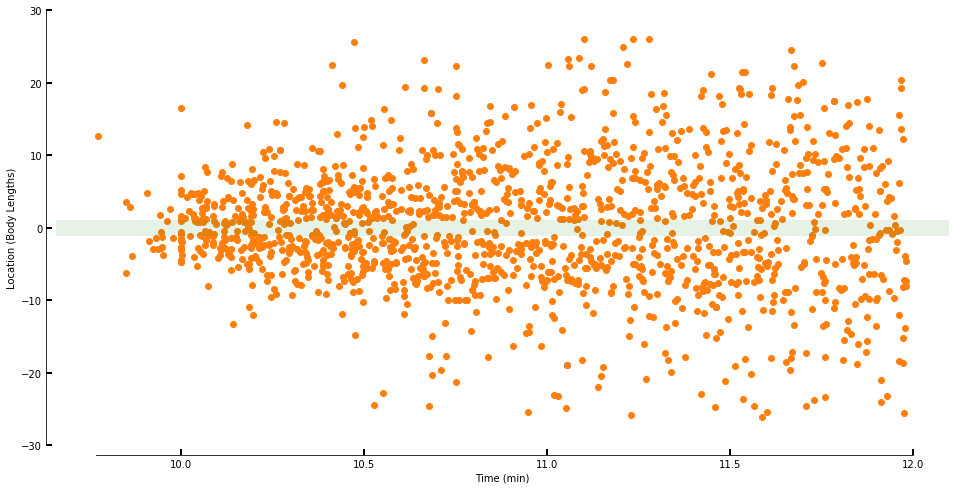

In [233]:
#Theta and t scatter plot

plt.figure(figsize=(16,8))
ax = plt.subplot()

theta_rev_filename = 'trial_reversals/RE_af1_all_1F.txt'
t_rev_filename = 'trial_reversals/t_af1_all_1F.txt'

theta_rev_signal_long = np.loadtxt(theta_rev_filename)
t_rev_signal_long = np.loadtxt(t_rev_filename)

t_rev_signal = np.reshape(t_rev_signal_long,(23,6,50))
theta_rev_signal = np.reshape(theta_rev_signal_long,(23,6,50))

t_rev_signal[np.abs(t_rev_signal)<0.01] = np.nan
theta_rev_signal[np.abs(theta_rev_signal)<0.01] = np.nan

t_rev_signal[t_rev_signal<9.] = t_rev_signal[t_rev_signal<9.] + 5.

theta_rev_signal = rads_to_bls(theta_rev_signal)


for fly in range(23):
    t_rev_signal[fly,np.logical_not(which_trials_bool[fly,:]),:] = np.nan
    theta_rev_signal[fly,np.logical_not(which_trials_bool[fly,:]),:] = np.nan

plt.scatter(t_rev_signal[1,0,:],theta_rev_signal[1,0,:])
plt.scatter(t_rev_signal,theta_rev_signal)


plt.ylabel('Location (Body Lengths)')
food_width = degs_to_bls(15.)

#Food location bar
plt.axhspan(-1*food_width/2,food_width/2, facecolor='g', alpha=0.1,label='food') 
d_max = 30
plt.ylim([-1*d_max,1*d_max])
plt.xlabel('Time (min)')

adjust_spines(ax,['left','bottom'])


plt.show()


#We need to use  to select the appropriate trials for each fly.

In [293]:
def plot_traces_with_revs(fly_num,which_trials,show_led=False):
     
    #fly_num: which fly ids to plot (1-indexed!)
    #which_trials: a matrix specifying which trials to include for each fly (1-indexed!)
    #which_periods: for each fly, 3-element bool specifying whether to show [before,during,after] (0-indexed)
    #d_max: the theta bounds to use for the plot
    #show_led: (we don't have it yet 9/23)
    
    file_loc = '5by5_data_923/Annie_Data_trial_1food/'
          
    which_trial_list = np.arange(which_trials[0],which_trials[1]+1)
    shape = (6,num_time_steps)
    num_trials = 6
    theta_signals = np.full(shape,np.nan)
    t_signals = np.full(shape,np.nan)
    
    for trial in which_trial_list:
        
        
                #Check if this fly-trial pair the food was found and skip if not
        if(which_trials_bool[fly_num-1,trial-1]): 

            start_t_ind = 0

            period_ind = 2

            theta_filename = file_loc+'theta_1F_'+\
                ['be','du','af'][period_ind]+'_'+\
                str(fly_num)+'_'+\
                str(trial)+'.txt'

            t_filename = file_loc+'t_1F_'+\
                ['be','du','af'][period_ind]+'_'+\
                str(fly_num)+'_'+\
                str(trial)+'.txt'

            theta_signal = pd.read_csv(theta_filename).values.T[0]
            t_signal = pd.read_csv(t_filename).values.T[0]

            while (t_signal[0]<period_ind*5):
                t_signal = t_signal + 5

            len_signal = len(t_signal)
            
            t_signals[trial-1,start_t_ind:start_t_ind+len_signal] = t_signal       
            theta_signals[trial-1,start_t_ind:start_t_ind+len_signal] = theta_signal      

            start_t_ind+=len_signal

    
   
    plt.figure(figsize=(16,8))
    ax = plt.subplot()

    colormap = cm.get_cmap('viridis',num_trials)
    colors = colormap(np.linspace(0,1,num_trials)) 
    
    for trial in which_trial_list:
        plt.plot(t_signals[trial-1,:],rads_to_bls(theta_signals[trial-1,:]),'.',markersize=1,color=colors[trial-1])  
  
    
    plt.ylabel('Location (Body Lengths)')
    food_width = degs_to_bls(15.)
    
    
    #Food location bar
    plt.axhspan(-1*food_width/2,food_width/2, facecolor='g', alpha=0.1,label='food') 

    #theta_rev_signal: shape  (23,6,50) : flies by trials by reversals (exclude reversal index 0)
    max_revs = 25
    which_trial_inds = np.arange(which_trials[0]-1,which_trials[1]).astype(int)            
    #plt.scatter(t_rev_signal[fly_num-1,which_trial_inds,:max_revs],
     #           theta_rev_signal[fly_num-1,which_trial_inds,:max_revs],color='r',s=50,zorder=1)
    plt.ylim([-1*d_max,1*d_max])
    plt.xlabel('Time (min)')
#     plt.xlim([np.min(t_signal),t_max])

    adjust_spines(ax,['left','bottom'])

    

    
    plt.show()
    

#fly_num: which fly ids to plot
#which_trials: a matrix specifying which trials to include (for each fly)
#which_periods: for each fly, 3-element bool specifying whether to show [before,during,after]
#d_max: the theta bounds to use for the plot
#show_led: (we don't have it yet 9/23)    


#start,stop,step,init
sfly_num = intslider('fly_num',1,num_flies,1,1)
swhich_trials = widgets.IntRangeSlider(
    value=[1,2],
    description='which_trials',
    min=1,
    max=6,
    step=1,
    orientation='horizontal')

sliders = [sfly_num,swhich_trials]
items = [Box([slider]) for slider in sliders]
  

ui = Box(items, layout=Layout(
    display='flex',
    flex_flow='column',
    border='solid 2px',
    align_items='stretch',
    width='30%'
))

slider_names = [slider.description for slider in sliders]
param_dict =  dict(zip(slider_names,sliders))


out = widgets.interactive_output(plot_traces_with_revs, param_dict)



display(ui,out)

Box(children=(Box(children=(IntSlider(value=1, continuous_update=False, description='fly_num', max=23, min=1),…

Output()

Now we are looking at the k_is for the trial structure and looking at between-fly variation.

In [292]:
#theta_signal: shape  (23,6,50) : flies by trials by reversals (exclude reversal index 0)

def plot_kis(fly_num,which_trials,theta_rev_signal=theta_rev_signal):

    k_is = np.full(np.shape(theta_signal),np.nan)
    irds_all = np.full(np.shape(theta_signal),np.nan)
    irds_shifted_all = np.full(np.shape(theta_signal),np.nan)
    r0s_by_trial = np.full((23,6),np.nan) #1 r_0 for every fly-trial pair

    for fly in range(23):
        for trial in range(6):
            if which_trials_bool[fly,trial]:
                irds = np.abs(np.diff(theta_rev_signal[fly,trial,:]))
                irds_all[fly,trial,:-1] = irds
                r0 = np.abs(theta_rev_signal[fly,trial,0])
                irds_shifted_all[fly,trial,:-1] = irds - r0 
                ratios = irds[1:]/irds[:-1]
                k_is[fly,trial,:-2] = ratios
                r0s_by_trial[fly,trial] = r0
    
    
    max_revs = 25
    inds = np.arange(1,max_revs+1,1)
    inds_rep = np.tile(inds, (6, 1))

    fig = plt.figure(figsize=(16,8))
    gs = GridSpec(2,6)
    
    ax1 = fig.add_subplot(gs[0,0:4])
     
    which_trial_inds = np.arange(which_trials[0]-1,which_trials[1]).astype(int)   
        
    plt.plot(inds_rep.T,k_is[fly_num-1,which_trial_inds,:max_revs].T,'-o')
    
    plt.ylabel('k_is')
    plt.xlabel('Index')    
    plt.ylim([0,5])
    plt.xlim([1,25])
    adjust_spines(ax1,['left','bottom'])
    
    ax2 = fig.add_subplot(gs[1,0:4])
    
    plt.plot(inds_rep.T,irds_all[fly_num-1,which_trial_inds,:max_revs].T,'-o')
    plt.ylabel('inter-reversal distances')
    plt.xlabel('Index')    
    plt.ylim([0,45])
    plt.xlim([1,25])
    adjust_spines(ax2,['left','bottom'])

    ax3 = fig.add_subplot(gs[1,4:6])
    to_plot = irds_all[fly_num-1,which_trial_inds,:max_revs].flatten()   
    plt.eventplot(to_plot,lineoffsets=0,linelengths=1,alpha=0.2)
    #print(r0s_by_trial[fly_num-1,which_trial_inds])
    plt.eventplot(r0s_by_trial[fly_num-1,which_trial_inds],color='r',lineoffsets=0,linelengths=1,alpha=1.)

    plt.ylim([0,0.3])
    plt.yticks([])
    plt.xlabel('IRD Value (BLs)')    
    plt.xlim([-10,50])
    

    ax4 = fig.add_subplot(gs[0,4:6])
    to_plot = irds_shifted_all[fly_num-1,which_trial_inds,:max_revs].flatten()   
    plt.eventplot(to_plot,lineoffsets=0,linelengths=1,alpha=0.2)
   
    plt.ylim([0,0.3])
    plt.yticks([])
    plt.xlabel('IRD Value (BLs) Shifted')    
    plt.xlim([-10,50])
    
    
    
    plt.show()

    
sfly_num = intslider('fly_num',1,num_flies,1,1) 
swhich_trials = widgets.IntRangeSlider(
    value=[1,2],
    description='which_trials',
    min=1,
    max=6,
    step=1,
    orientation='horizontal')


sliders = [sfly_num,swhich_trials]
items = [Box([slider]) for slider in sliders]

ui = Box(items, layout=Layout(
    display='flex',
    flex_flow='column',
    border='solid 2px',
    align_items='stretch',
    width='30%'
))

slider_names = [slider.description for slider in sliders]
param_dict =  dict(zip(slider_names,sliders))

out = widgets.interactive_output(plot_kis, param_dict)

display(ui,out)


Box(children=(Box(children=(IntSlider(value=1, continuous_update=False, description='fly_num', max=23, min=1),…

Output()

In [274]:
#theta_signal: shape  (23,6,50) : flies by trials by reversals (exclude reversal index 0)

def plot_irds_hist(fly_num,theta_signal=theta_signal):

    irds_all = np.full(np.shape(theta_signal),np.nan)

    for fly in range(23):
        for trial in range(6):
            if which_trials_bool[fly,trial]:
                irds = np.abs(np.diff(theta_signal[fly,trial,1:]))
                irds_all[fly,trial,:-2] = irds
               
    
    max_revs = 25
    inds = np.arange(1,max_revs+1,1)
    inds_rep = np.tile(inds, (6, 1))

    plt.figure(figsize=(8,8))
    ax1 = plt.subplot(211)
     
    #which_fly_inds = np.arange(which_flies[0]-1,which_flies[1]).astype(int)   
    #to_plot = irds_all[which_fly_inds,:,:max_revs].flatten() 
    to_plot = irds_all[fly_num-1,:,:max_revs].flatten()   
    plt.eventplot(to_plot,lineoffsets=0,linelengths=1)

    plt.ylim([0,0.3])
    plt.ylabel('Freq')
    plt.xlabel('IRD Value (BLs)')    
    #plt.ylim([0,5])
    plt.xlim([0,50])
    adjust_spines(ax1,['left','bottom'])
    
    plt.show()

    
sfly_num = intslider('fly_num',1,num_flies,1,1)
    
swhich_flies = widgets.IntRangeSlider(
    value=[1,2],
    description='which_flies',
    min=1,
    max=23,
    step=1,
    orientation='horizontal')


sliders = [sfly_num]#swhich_flies]
items = [Box([slider]) for slider in sliders]

ui = Box(items, layout=Layout(
    display='flex',
    flex_flow='column',
    border='solid 2px',
    align_items='stretch',
    width='30%'
))

slider_names = [slider.description for slider in sliders]
param_dict =  dict(zip(slider_names,sliders))

out = widgets.interactive_output(plot_irds_hist, param_dict)

display(ui,out)


Box(children=(Box(children=(IntSlider(value=1, continuous_update=False, description='fly_num', max=23, min=1),…

Output()

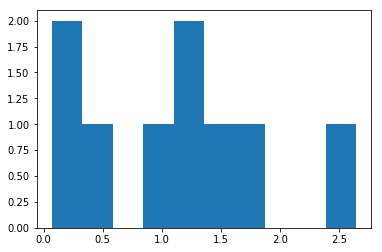

In [198]:
#(flies x trials x theta instances)
theta_i_ratios = np.full(np.shape(theta_signal),np.nan)

#Compute theta_i ratios
for fly in range(23):
    for trial in range(6):
        if which_trials_bool[fly,trial]:
            ratios = np.abs(theta_signal[fly,trial,1:]/theta_signal[fly,trial,:-1])
            ratios[np.isinf(ratios)] = 0.
            theta_i_ratios[fly,trial,:-1] = ratios

theta_i_ratios[theta_i_ratios>=3.] = np.nan

plt.figure()
plt.hist(theta_i_ratios[1,:,:].flatten())
plt.show()

Now, let's put all of the plots on top of each other!

In [124]:
def plot_many_traces(which_trial,which_periods,which_flies_list,d_max):
    
    which_flies_list = np.arange(which_flies_list[0],which_flies_list[1]+1)
     
    #fly_num: which fly ids to plot (1-indexed!)
    #which_trials: a matrix specifying which trials to include for each fly (1-indexed!)
    #which_periods: for each fly, 3-element bool specifying whether to show [before,during,after] (0-indexed)
    #d_max: the theta bounds to use for the plot
    #show_led: (we don't have it yet 9/23)
    
    file_loc = '5by5_data_923/Annie_Data_trial_1food/'
       
    which_periods_nums= [{'before':0,'during':1,'after':2}[which_period] for which_period in which_periods]
      
    #Each of theta_signals and t_signals will have the shape:
    # (num_flies x num_time_steps)
    
    shape = (num_flies,num_time_steps)
    theta_signals = np.full(shape,np.nan)
    t_signals = np.full(shape,np.nan)

    for fly_num in which_flies_list:
        
        #Check if this fly-trial pair the food was found and skip if not
        if(which_trials_bool[fly_num-1,which_trial-1]): 
            start_t_ind = 0

            for period_ind in which_periods_nums:

                theta_filename = file_loc+'theta_1F_'+\
                    ['be','du','af'][period_ind]+'_'+\
                    str(fly_num)+'_'+\
                    str(which_trial)+'.txt'

                t_filename = file_loc+'t_1F_'+\
                    ['be','du','af'][period_ind]+'_'+\
                    str(fly_num)+'_'+\
                    str(which_trial)+'.txt'

                theta_signal = pd.read_csv(theta_filename).values.T[0]
                t_signal = pd.read_csv(t_filename).values.T[0]

                while (t_signal[0]<period_ind*5):
                    t_signal = t_signal + 5

                len_signal = len(t_signal)

                t_signals[fly_num-1,start_t_ind:start_t_ind+len_signal] = t_signal       
                theta_signals[fly_num-1,start_t_ind:start_t_ind+len_signal] = theta_signal      

                start_t_ind+=len_signal

    plt.figure(figsize=(16,8))
    ax = plt.subplot()
    colormap = cm.get_cmap('viridis',num_flies)
    colors = colormap(np.linspace(0,1,num_flies))
    for fly in which_flies_list:
         plt.plot(t_signals[fly-1,:],rads_to_bls(theta_signals[fly-1,:]),'.',markersize=1,color=colors[fly])  
    
#     plt.plot(t_signal.T,rads_to_bls(theta_signal).T,'.',markersize=1,color='b')
    plt.ylabel('Location (Body Lengths)')
    food_width = degs_to_bls(15.)
    
    
    #Food location bar
    plt.axhspan(-1*food_width/2,food_width/2, facecolor='g', alpha=0.1,label='food') 

      
    plt.ylim([-1*d_max,1*d_max])
    plt.xlabel('Time (min)')
#     plt.xlim([np.min(t_signal),t_max])

    adjust_spines(ax,['left','bottom'])

    
    #Flag if the food was not found
    
#     if not(which_trials_bool[fly_num-1,which_trials-1]):
#         ax.text(0.5,0.5,'FOOD NOT FOUND',fontsize=30,
#                 transform=ax.transAxes,
#                 verticalalignment='center',
#                 horizontalalignment='center')

    
    plt.show()
    

#fly_num: which fly ids to plot
#which_trials: a matrix specifying which trials to include (for each fly)
#which_periods: for each fly, 3-element bool specifying whether to show [before,during,after]
#d_max: the theta bounds to use for the plot
#show_led: (we don't have it yet 9/23)    


#start,stop,step,init
swhich_trial = intslider('which_trial',1,6,1,1)
sd_max = slider('d_max',10,50,5,30)


which_periods_toggle = widgets.SelectMultiple(
    options=['before','during','after'],
    value=['after'],
    description='which_periods',
    disabled=False)

swhich_flies_list = widgets.IntRangeSlider(
    value = [1,5],
    min=1,
    max=num_flies+1,
    step=1,
    orientation='horizontal',
    description='which_flies_list'
)

np.arange(1,num_flies+1,1)

# show_led_toggle = widgets.RadioButtons(options=[('False',0),('True',1)],disabled=False,description='show_led')


sliders = [swhich_trial,which_periods_toggle,swhich_flies_list,sd_max]
items = [Box([slider]) for slider in sliders]
  

ui = Box(items, layout=Layout(
    display='flex',
    flex_flow='column',
    border='solid 2px',
    align_items='stretch',
    width='30%'
))

slider_names = [slider.description for slider in sliders]
param_dict =  dict(zip(slider_names,sliders))

out = widgets.interactive_output(plot_many_traces, param_dict)



display(ui,out)

Box(children=(Box(children=(IntSlider(value=1, continuous_update=False, description='which_trial', max=6, min=…

Output()